# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



# Дмитрий_Золотарев_384785603

### Установка зависимостей

In [1]:
from platform import python_version
print(python_version())

3.9.13


In [2]:
import torch

torch.__version__

'2.0.0+cu118'

In [3]:
# установка подходящей версии torch

from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

C:\Users\dimka\PycharmProjects\DeepLEarningSchool_MFTI\venv\lib\site-packages\wheel\pep425tags.py:80: RuntimeWarning: Config variable 'Py_DEBUG' is unset, Python ABI tag may be incorrect
  if get_flag('Py_DEBUG',


In [4]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [5]:
from PIL import Image
import PIL
print(PIL.__version__)
# здесь должна быть версия 5.3.0. если это не так перезагрузите данный ноутбук:
# Menu > Runtime > Restart Runtime

9.5.0


In [6]:
!nvidia-smi
import torch
torch.cuda.is_available()

Fri Apr 21 10:41:06 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.68                 Driver Version: 531.68       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650       WDDM | 00000000:01:00.0 Off |                  N/A |
| N/A   54C    P8                3W /  N/A|     44MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [7]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [8]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [9]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),

            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15)

            # будем нормализовать сами
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')

        x = transform(x)

        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [10]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [11]:
TRAIN_DIR = Path('train/dataset')
TEST_DIR = Path('test/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [12]:
print(train_val_files.__len__(), test_files.__len__())

20933 991


In [13]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels)

In [14]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Давайте посмотрим на наших героев внутри датасета.

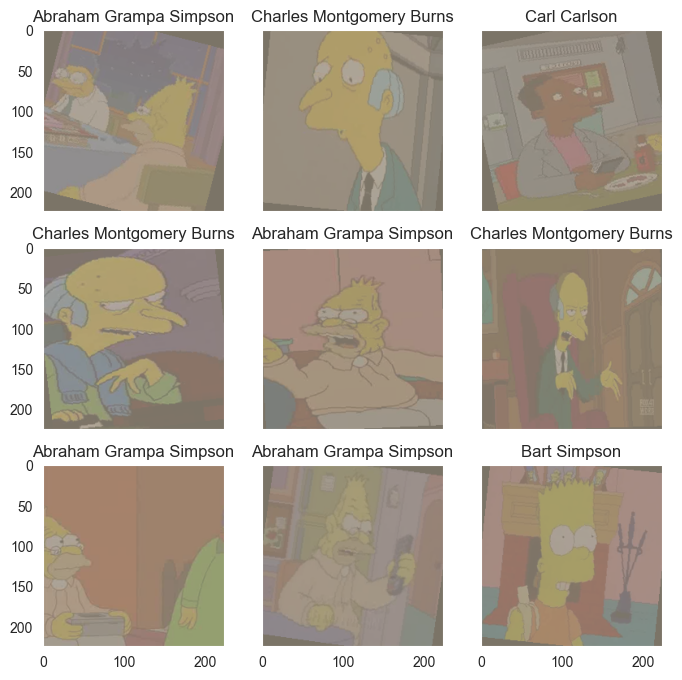

In [15]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(), val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [16]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [17]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    # Determine nums for normalization
    data = next(iter(train_loader))[0]
    mean = data.mean(dim=(0, 2, 3)) # среднее по батчу 0, по ширине 2 и высоте 3
    std = data.std(dim=(0, 2, 3)) # the same

    normalize = transforms.Normalize(mean=mean, std=std)

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Normalization
        inputs = normalize(inputs)
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [18]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    # Determine nums for normalization
    data = next(iter(train_loader))[0]
    mean = data.mean(dim=(0, 2, 3)) # среднее по батчу 0, по ширине 2 и высоте 3
    std = data.std(dim=(0, 2, 3)) # the same

    normalize = transforms.Normalize(mean=mean, std=std)

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        inputs = normalize(inputs)

        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)

    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [19]:
def train(train_files, val_files, model, epochs, batch_size, opt=None):
    max_val_acc = 0
    best_val_acc = 0
    best_model_wts = 0

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        # Changed to AdamW
        if opt is None:
            opt = torch.optim.Adam(model.parameters(), lr=1e-4)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

            if val_acc > max_val_acc:
                best_val_acc = val_acc
                best_model_wts = model.state_dict()

    return history, (best_model_wts, best_val_acc)

In [20]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [21]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

Запустим обучение сети.

In [22]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [23]:
history, _ = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=64)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]

loss 3.1244458251185034


epoch:  50%|█████     | 1/2 [02:29<02:29, 149.02s/it]


Epoch 001 train_loss: 3.1244     val_loss 2.8493 train_acc 0.1218 val_acc 0.2138
loss 2.3840971112410743


epoch: 100%|██████████| 2/2 [04:51<00:00, 145.67s/it]


Epoch 002 train_loss: 2.3841     val_loss 2.1403 train_acc 0.3500 val_acc 0.4177


Построим кривые обучения

In [24]:
loss, acc, val_loss, val_acc = zip(*history)

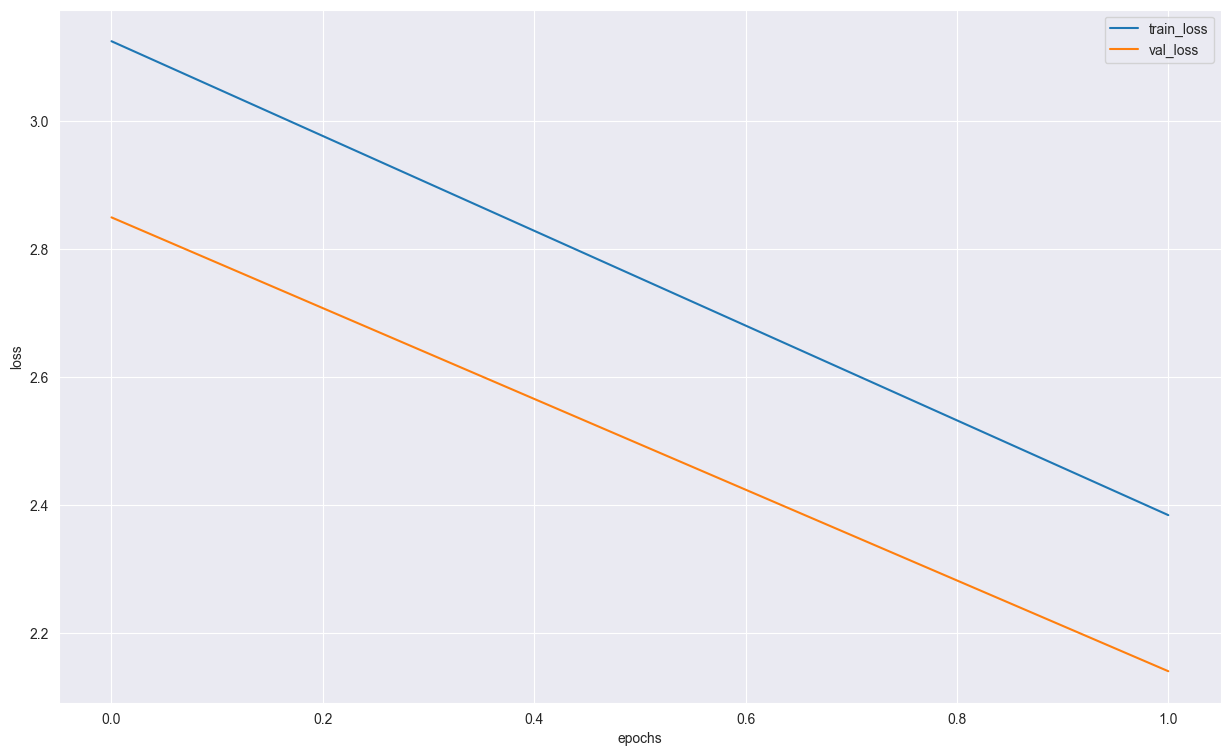

In [25]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [23]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [27]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [28]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [24]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [30]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [31]:
from sklearn.metrics import f1_score

f1_score([label_encoder.classes_[i] for i in actual_labels],
         preds_class, average='micro')


0.25

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

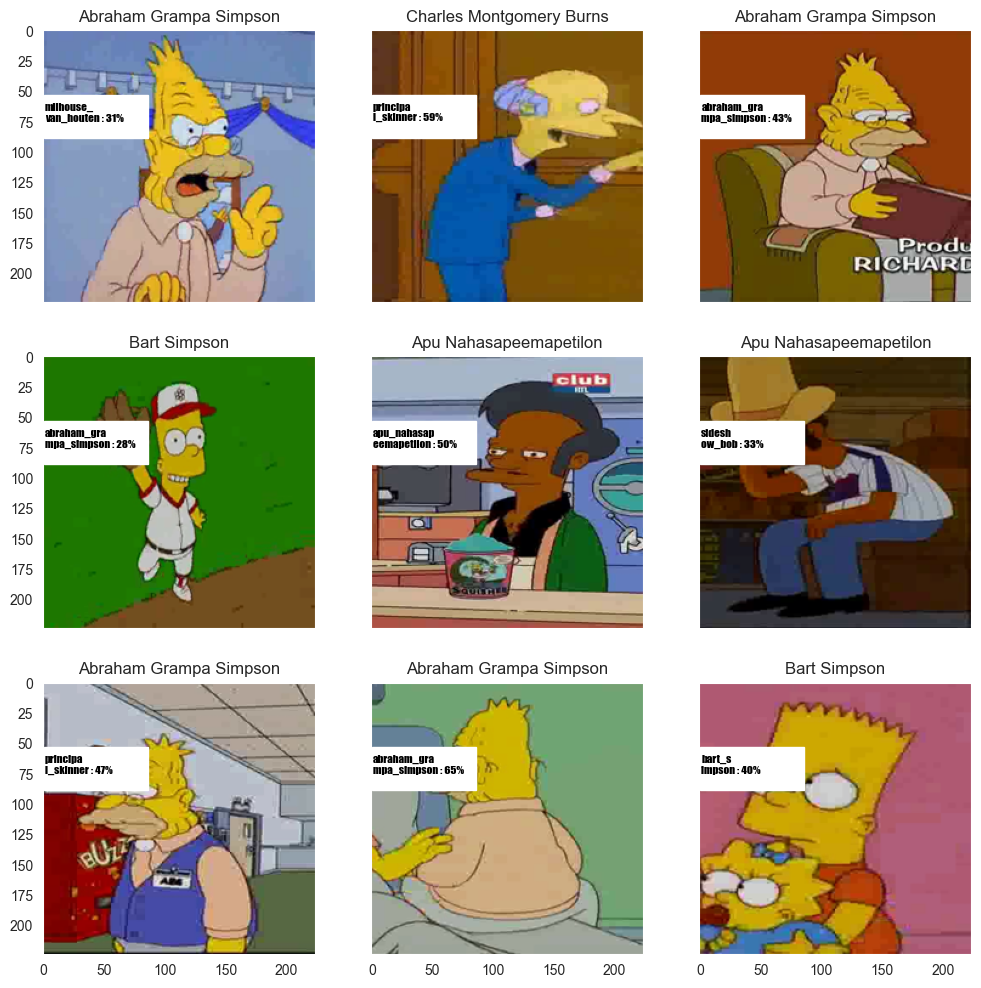

In [32]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [25]:
import pandas as pd

def get_submit(model, test_loader):
    probs = predict(model, test_loader)
    preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))

    test_filenames = [path.name for path in test_dataset.files]
    my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})

    return my_submit

def save_submit(submit, name_of_file):
    submit.to_csv(name_of_file, index=False)

In [26]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)

In [29]:
my_submit = get_submit(model=simple_cnn, test_loader=test_loader)
save_submit(submit=my_submit, name_of_file='simple_cnn_baseline.csv')

my_submit.head()

,Id,Expected
0,img0.jpg,ralph_wiggum
1,img1.jpg,ralph_wiggum
2,img10.jpg,ralph_wiggum
3,img100.jpg,lisa_simpson
4,img101.jpg,ralph_wiggum


*Курсив*## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)


# RESNET

In [27]:
from torchvision.models import ResNet152_Weights
import torch

model_resnet152 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', weights=ResNet152_Weights.DEFAULT)

Using cache found in C:\Users\dimka/.cache\torch\hub\pytorch_vision_v0.10.0


In [28]:
model_resnet152 = model_resnet152.to(DEVICE)

In [29]:
# let's freeze params
count = 0
for param in model_resnet152.parameters():
    param.requires_grad = False
    count += 1

count # 467 миллионов параметров*

467

In [30]:
from torchsummary import summary

summary(model_resnet152, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## Обучение

- обучаем сначала с замороженными весами, то есть последний слой классификатор
- размораживаем послений блок layer4
- размораживаем layer3

In [82]:
for param in model_resnet152.layer4.parameters():
    param.requires_grad = True

In [32]:
# changed last layer
model_resnet152.fc = nn.Linear(2048, 42).to(DEVICE)

for param in model_resnet152.fc.parameters():
    print(param.requires_grad) # убеждаемся что слой не заморожен

True
True


In [36]:
summary(model_resnet152, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [37]:
adamW = torch.optim.AdamW(filter(lambda param: param.requires_grad, model_resnet152.parameters()),
                         lr=1e-4, betas=(0.9,0.999), eps=1e-08, weight_decay=0.01, amsgrad=True)

history, (best_model_wts, best_acc) = train(train_dataset, val_dataset, model=model_resnet152, epochs=5, batch_size=64, opt=adamW)

epoch:   0%|          | 0/5 [03:16<?, ?it/s]

KeyboardInterrupt



In [62]:
torch.save(model_resnet152.state_dict(), "model_resnet152_5epoch_unfreeze_4layers.pt")
torch.save(best_model_wts, "best_model_resnet152_5epoch_unfreeze_4layers.pt")

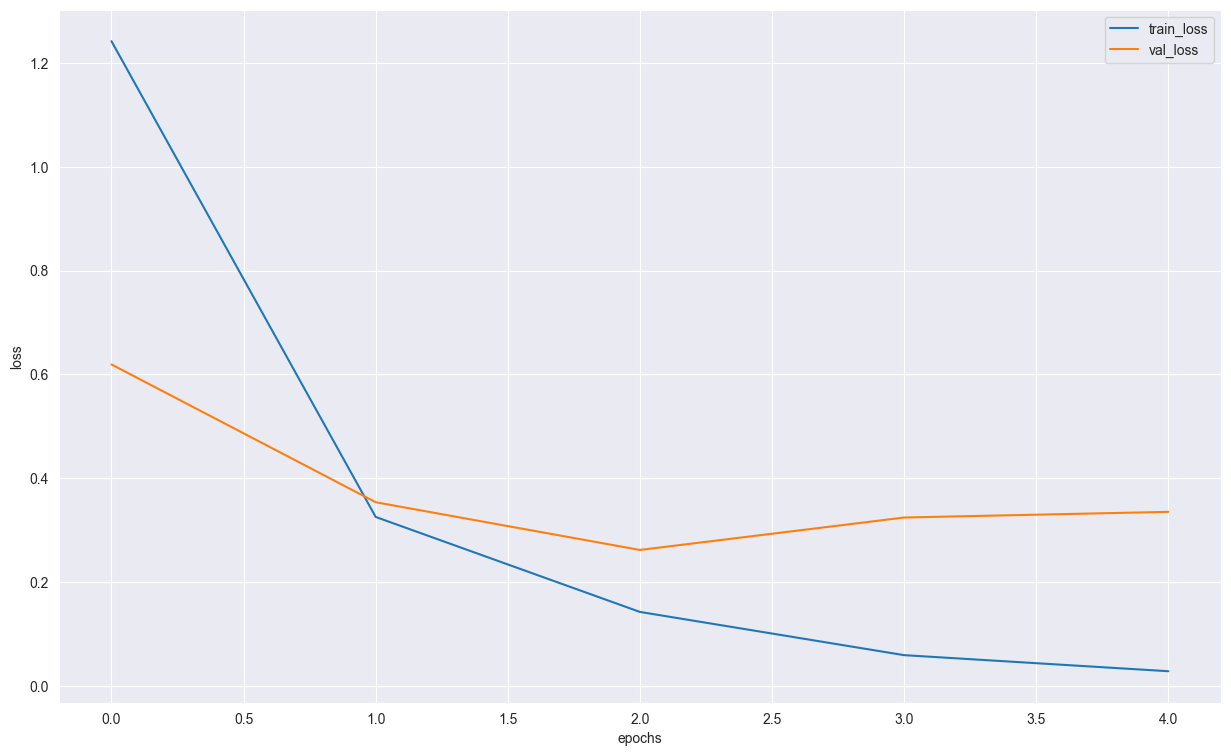

In [63]:
loss, acc, val_loss, val_acc = zip(*history)

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## Предсказывание

In [33]:
model_resnet152.load_state_dict(torch.load("best_model_resnet152_10epoch_with_aug_with_aug.pt"))

<All keys matched successfully>

In [34]:
my_submit = get_submit(model=model_resnet152, test_loader=test_loader)

In [35]:
save_submit(submit=my_submit, name_of_file='resnet152_baseline.csv')

my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


### Score 1: 0.96918

# Обучение после добавлении аугментации

In [90]:
adamW = torch.optim.AdamW(filter(lambda param: param.requires_grad, model_resnet152.parameters()),
                         lr=1e-4, betas=(0.9,0.999), eps=1e-08, weight_decay=0.01, amsgrad=True)

history, (best_model_wts, best_acc) = train(train_dataset, val_dataset, model=model_resnet152, epochs=10, batch_size=64, opt=adamW)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 1.4102905822966583


epoch:  10%|█         | 1/10 [08:11<1:13:46, 491.83s/it]


Epoch 001 train_loss: 1.4103     val_loss 0.6033 train_acc 0.6676 val_acc 0.8554
loss 0.3605313595597687


epoch:  20%|██        | 2/10 [16:21<1:05:23, 490.43s/it]


Epoch 002 train_loss: 0.3605     val_loss 0.4228 train_acc 0.9058 val_acc 0.8903
loss 0.20464022759319916


epoch:  30%|███       | 3/10 [24:24<56:50, 487.24s/it]  


Epoch 003 train_loss: 0.2046     val_loss 0.3174 train_acc 0.9434 val_acc 0.9161
loss 0.13521264643530626


epoch:  40%|████      | 4/10 [32:31<48:43, 487.24s/it]


Epoch 004 train_loss: 0.1352     val_loss 0.3253 train_acc 0.9627 val_acc 0.9165
loss 0.10597527157139472


epoch:  50%|█████     | 5/10 [40:37<40:33, 486.65s/it]


Epoch 005 train_loss: 0.1060     val_loss 0.3188 train_acc 0.9717 val_acc 0.9194
loss 0.06462599458204359


epoch:  60%|██████    | 6/10 [48:41<32:23, 485.83s/it]


Epoch 006 train_loss: 0.0646     val_loss 0.3207 train_acc 0.9824 val_acc 0.9268
loss 0.0562772339918899


epoch:  70%|███████   | 7/10 [56:43<24:13, 484.41s/it]


Epoch 007 train_loss: 0.0563     val_loss 0.3361 train_acc 0.9838 val_acc 0.9198
loss 0.05016867104995538


epoch:  80%|████████  | 8/10 [1:04:56<16:14, 487.29s/it]


Epoch 008 train_loss: 0.0502     val_loss 0.2944 train_acc 0.9855 val_acc 0.9316
loss 0.04162734853276626


epoch:  90%|█████████ | 9/10 [1:13:13<08:10, 490.16s/it]


Epoch 009 train_loss: 0.0416     val_loss 0.3081 train_acc 0.9892 val_acc 0.9280
loss 0.036884656526277405


epoch: 100%|██████████| 10/10 [1:21:12<00:00, 487.27s/it]


Epoch 010 train_loss: 0.0369     val_loss 0.3909 train_acc 0.9903 val_acc 0.9119


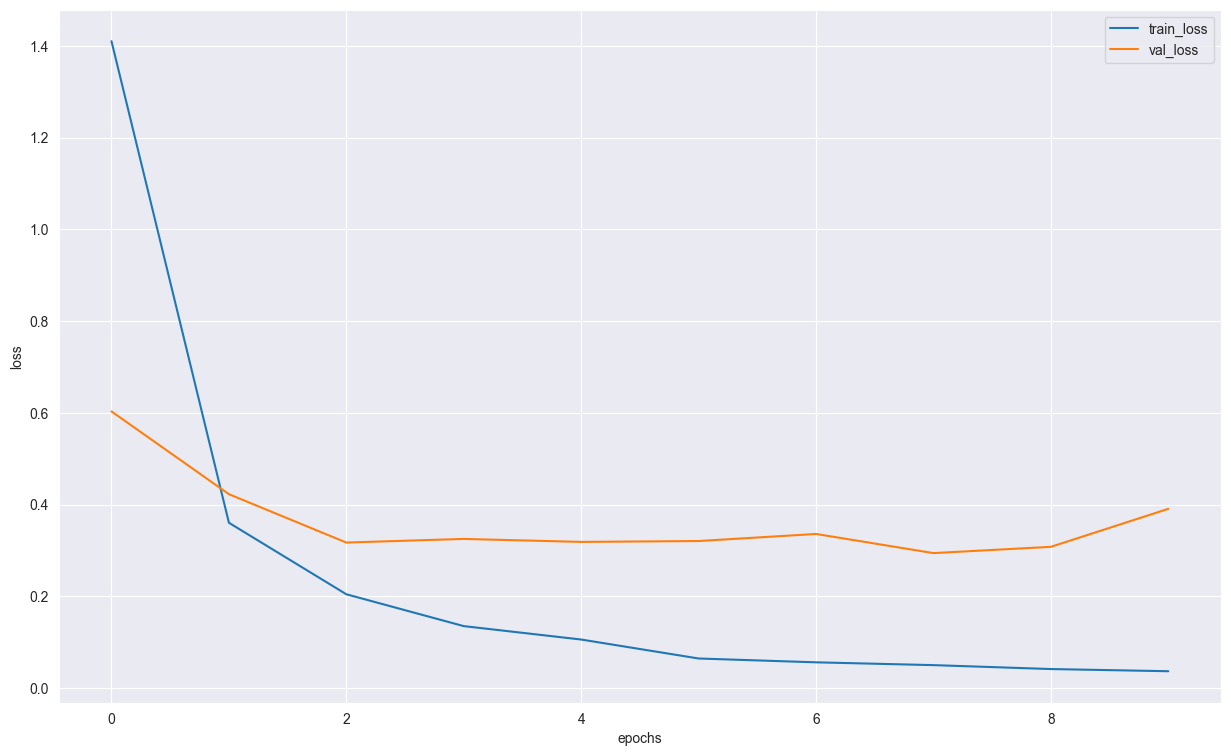

In [91]:
loss, acc, val_loss, val_acc = zip(*history)

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [92]:
torch.save(model_resnet152.state_dict(), "model_resnet152_10epoch_with_aug.pt")
torch.save(best_model_wts, "best_model_resnet152_10epoch_with_aug_with_aug.pt")

## Попытка номер 2
забыл нормировать данные и в eval_epoch

In [94]:
from torchvision.models import ResNet152_Weights
from torchsummary import summary
import torch

model_resnet152_2 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', weights=ResNet152_Weights.DEFAULT)
model_resnet152_2 = model_resnet152.to(DEVICE)

# let's freeze params
for param in model_resnet152_2.parameters():
    param.requires_grad = False

summary(model_resnet152, (3, 224, 224))

Using cache found in C:\Users\dimka/.cache\torch\hub\pytorch_vision_v0.10.0


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [95]:
for param in model_resnet152.layer4.parameters():
    param.requires_grad = True

### Обучение на последнем слое (их всего 4)

In [96]:
adamW = torch.optim.AdamW(filter(lambda param: param.requires_grad, model_resnet152.parameters()),
                         lr=1e-4, betas=(0.9,0.999), eps=1e-08, weight_decay=0.01, amsgrad=True)

history1, (best_model_wts, best_acc) = train(train_dataset, val_dataset, model=model_resnet152, epochs=5, batch_size=64, opt=adamW)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 0.03643357968833175


epoch:  20%|██        | 1/5 [08:00<32:03, 480.99s/it]


Epoch 001 train_loss: 0.0364     val_loss 0.3341 train_acc 0.9897 val_acc 0.9261
loss 0.042402238990901196


epoch:  40%|████      | 2/5 [16:01<24:01, 480.53s/it]


Epoch 002 train_loss: 0.0424     val_loss 0.3345 train_acc 0.9879 val_acc 0.9220
loss 0.02129341822820375


epoch:  60%|██████    | 3/5 [24:00<16:00, 480.16s/it]


Epoch 003 train_loss: 0.0213     val_loss 0.2794 train_acc 0.9942 val_acc 0.9366
loss 0.026173311332773872


epoch:  80%|████████  | 4/5 [32:00<08:00, 480.01s/it]


Epoch 004 train_loss: 0.0262     val_loss 0.3164 train_acc 0.9918 val_acc 0.9339
loss 0.0280972025093493


epoch: 100%|██████████| 5/5 [40:01<00:00, 480.22s/it]


Epoch 005 train_loss: 0.0281     val_loss 0.3594 train_acc 0.9918 val_acc 0.9278


In [97]:
torch.save(model_resnet152.state_dict(), "model_resnet152_10epoch_with_aug.pt")
torch.save(best_model_wts, "best_model_resnet152_10epoch_with_aug_with_aug.pt")

### Score: 0.92

### Обучение на последних 2

In [98]:
for param in model_resnet152.layer3.parameters():
    param.requires_grad = True

In [ ]:
history2, (best_model_wts, best_acc) = train(train_dataset, val_dataset, model=model_resnet152, epochs=3, batch_size=64, opt=adamW)

epoch:   0%|          | 0/3 [00:04<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 50.00 MiB (GPU 0; 4.00 GiB total capacity; 3.20 GiB already allocated; 0 bytes free; 3.40 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
loss1, acc1, val_loss1, val_acc1 = zip(*history1)
loss2, acc2, val_loss2, val_acc2 = zip(*history2)

plt.figure(figsize=(15, 9))
plt.plot(loss1, label="train_loss")
plt.plot(loss2, label="train_loss")
plt.plot(val_loss1, label="val_loss")
plt.plot(val_loss2, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
torch.save(model_resnet152_2.state_dict(), "model_resnet152_2_10epoch_with_aug.pt")
torch.save(best_model_wts, "best_model_resnet152_2_10epoch_with_aug_with_aug.pt")